In [1]:
# The task is to build a model of housing prices in California.  The model should learn from data and be able to
# predict the median housing price in any district.  In Exercise #1 we used the Support Vector Machine algorithm
# with kernels linear and rbf, and varying the C and Gamma parameters.  In Exercise2a we used the GridSearchCV
# method and compared the results with those from Exercise 1.  In this exercise we will use RandomizedSearchCV to
# determine the best hyperparameters and compare the results to Exer 2a.

#Read in housing data
import pandas as pd
housing = pd.read_csv('/home/erena/MachineLearning/housing.csv')
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
5,-122.25,37.85,52,919,213.0,413,193,4.0368,269700,NEAR BAY
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,299200,NEAR BAY
7,-122.25,37.84,52,3104,687.0,1157,647,3.1200,241400,NEAR BAY
8,-122.26,37.84,42,2555,665.0,1206,595,2.0804,226700,NEAR BAY
9,-122.25,37.84,52,3549,707.0,1551,714,3.6912,261100,NEAR BAY


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null int64
total_rooms           20640 non-null int64
total_bedrooms        20433 non-null float64
population            20640 non-null int64
households            20640 non-null int64
median_income         20640 non-null float64
median_house_value    20640 non-null int64
ocean_proximity       20640 non-null object
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

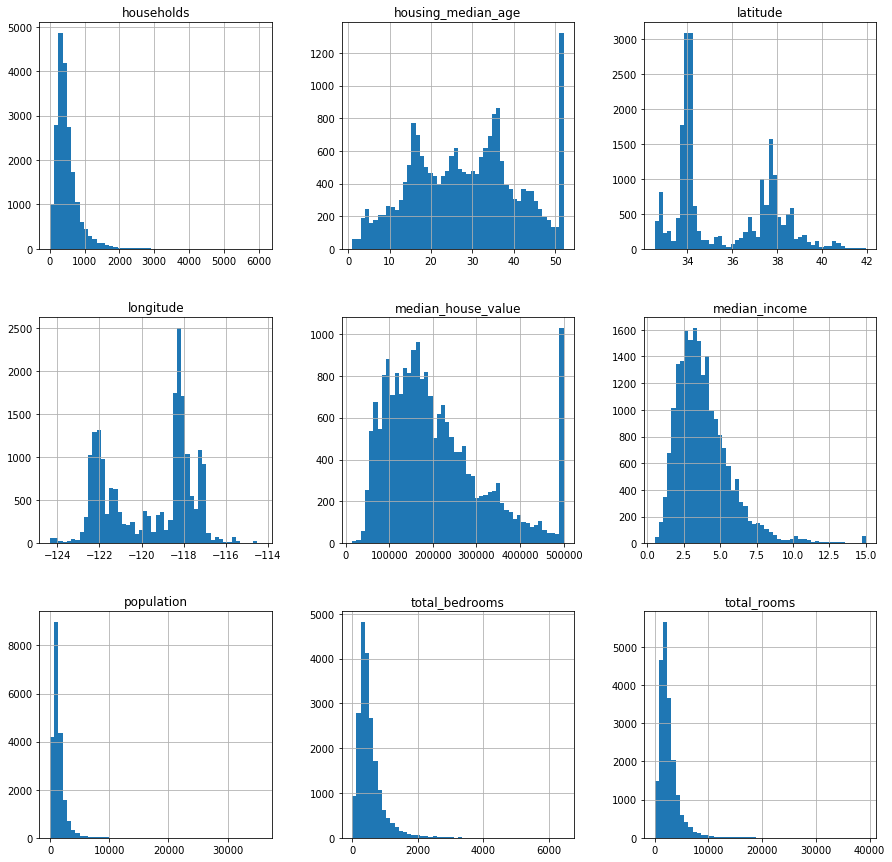

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(15,15))
plt.show()

In [6]:
import numpy as np
#housing["total_bedrooms"].value_counts()

In [7]:
#Determine how many missing values are in housing dataframe
housing.apply(lambda x: sum(x.isnull()), axis=0)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
#Fill missing values in total_bedrooms with mean of total_bedrooms
#From housing.describe(), mean of total_bedrooms is 538
housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean(), inplace=True)

#Could also do:   housing['total_bedrooms'].fillna(538, inplace = True)
#Could also use Imputer (see page 60, Ch.2, Hands-on ML)

In [9]:
housing.apply(lambda x: sum(x.isnull()), axis=0)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:
#Median income is an important attribute for predicting median housing prices.  According to the graph above, 
#median income is clustered between 20k and 50k with a long tail going out to 150k.  This data needs to be more
#uniform, so create a new category called "income_cat" in the data frame that evens out the samples.  This is 
#called 'stratified sampling'.
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing['income_cat'].value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

In [11]:
#Now put samples in income categories > 6 into one category.  The 'where' method checks the data.  If it is in a
#category less than 5, the data is left alone.  If it is in a category greater than 5, it is put into category 5.
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [12]:
#Now that the income data is more evenly distributed (giving a better attribute for fitting and predicting), we
#can split the data into training and testing sets.  Since the data has been stratified, use StratifiedShuffleSplit.
#The for loop loops over the number of splits. In this case there is only one split, so the for loop only runs once.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print("train_index: ", train_index)
strat_train_set.head(10)

train_index:  [17606 18632 14650 ... 13908 11159 15775]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38,1568,351.0,710,339,2.7042,286600,<1H OCEAN,2.0
18632,-121.93,37.05,14,679,108.0,306,113,6.4214,340600,<1H OCEAN,5.0
14650,-117.20,32.77,31,1952,471.0,936,462,2.8621,196900,NEAR OCEAN,2.0
3230,-119.61,36.31,25,1847,371.0,1460,353,1.8839,46300,INLAND,2.0
3555,-118.59,34.23,17,6592,1525.0,4459,1463,3.0347,254500,<1H OCEAN,3.0
19480,-120.97,37.66,24,2930,588.0,1448,570,3.5395,127900,INLAND,3.0
8879,-118.50,34.04,52,2233,317.0,769,277,8.3839,500001,<1H OCEAN,5.0
13685,-117.24,34.15,26,2041,293.0,936,375,6.0000,140200,INLAND,4.0
4937,-118.26,33.99,47,1865,465.0,1916,438,1.8242,95000,<1H OCEAN,2.0
4861,-118.28,34.02,29,515,229.0,2690,217,0.4999,500001,<1H OCEAN,1.0


In [13]:
#Now remove the 'income_cat' attribute so the data is back to its original state
strat_train_set.drop(['income_cat'], axis=1, inplace=True)
strat_test_set.drop(['income_cat'], axis=1, inplace=True)
housing.drop(['income_cat'], axis=1, inplace=True)

strat_test_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29,6447,1012.0,2184,960,8.2816,500001,<1H OCEAN
10970,-117.86,33.77,39,4159,655.0,1669,651,4.6111,240300,<1H OCEAN
20351,-119.05,34.21,27,4357,926.0,2110,876,3.0119,218200,<1H OCEAN
6568,-118.15,34.20,52,1786,306.0,1018,322,4.1518,182100,INLAND
13285,-117.68,34.07,32,1775,314.0,1067,302,4.0375,121300,INLAND
20552,-121.80,38.68,11,3851,892.0,1847,747,3.4331,120600,INLAND
19989,-119.32,36.19,11,1281,291.0,861,313,1.0962,72300,INLAND
17049,-122.26,37.46,26,5067,750.0,1996,728,7.0001,500001,NEAR OCEAN
13692,-117.24,34.13,26,3774,716.0,1913,620,3.3534,98900,INLAND
13916,-116.15,34.14,18,3312,705.0,1251,512,3.0139,82600,INLAND


In [14]:
#Create the feature matrix (X) and target array (y) for fitting and predicting.  Feature matrix is the housing 
#data frame without the median_house_value column.  The target array is the median_housing_values.  Note that the
#.drop method creates a copy of the data and does not affect the actual data frame values.
housing = strat_train_set.drop(['median_house_value'], axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

housing_labels.head(10)

17606    286600
18632    340600
14650    196900
3230      46300
3555     254500
19480    127900
8879     500001
13685    140200
4937      95000
4861     500001
Name: median_house_value, dtype: int64

In [15]:
#Let's look at housings' text data
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [16]:
#Machine learning algorithms work primarily with numbers, not text. We need to convert the ocean proximity data
#from text to numbers.  We can use Pandas' factorize() method to convert the string categorical features to 
#numerical categorical features.  Note this doesn't change the data frame.
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [17]:
type(housing_cat_encoded)

numpy.ndarray

In [18]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [19]:
#We are almost ready to put the data through a pipeline to transform and fit it.  We need a few custom methods to do
#this:  DataFrameSelector (to help Scikit Learn handle Pandas data frames), CombinedAttributesAdder (to add feature
#columns to the data frame), and CategoricalEncoder (to convert text data to numerical data).
#Note: These methods were basically copied from the online supplement to the textbook (Hands-on Machine Learning
#with SciKit-Learn and TensorFlow, Ch.2) since I am very new to Python and Machine Learning.

In [20]:
#Let's start with the DataFrameSelector
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [21]:
#Now let's do the CombinedAttributesAdder
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6   #column numbers in data frame

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):    #no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self    #nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
        

In [22]:
#And finally, we can use the new CategoricalEncoder method to convert the text data into numerical data.  

from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [23]:
#Housing data frame still has text data in 'ocean_proximity'.  We need to remove this feature.
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.head(10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38,1568,351.0,710,339,2.7042
18632,-121.93,37.05,14,679,108.0,306,113,6.4214
14650,-117.20,32.77,31,1952,471.0,936,462,2.8621
3230,-119.61,36.31,25,1847,371.0,1460,353,1.8839
3555,-118.59,34.23,17,6592,1525.0,4459,1463,3.0347
19480,-120.97,37.66,24,2930,588.0,1448,570,3.5395
8879,-118.50,34.04,52,2233,317.0,769,277,8.3839
13685,-117.24,34.15,26,2041,293.0,936,375,6.0000
4937,-118.26,33.99,47,1865,465.0,1916,438,1.8242
4861,-118.28,34.02,29,515,229.0,2690,217,0.4999


In [24]:
#Now let's put everything into a pipeline to get the data ready for the algorithms
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
print(num_attribs)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [25]:
cat_attribs = ["ocean_proximity"] 

num_pipeline = Pipeline([ ('selector', DataFrameSelector(num_attribs)),
                        ('imputer', Imputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler())])

cat_pipeline = Pipeline([ ('selector', DataFrameSelector(cat_attribs)),
                        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))])

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                              ("cat_pipeline", cat_pipeline)])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [26]:
# Using the same prepared data as in Exercise #1 and 2a, let's use RandomizedSearchCV to determine the best para-
# meters for a SVM regressor algorithm.  Kernel's are linear and rbf, parameters are gamma (0.01, 0.1, 1.0),  
# and C (10, 100,1000).  We may add more parameters and we will use 5-fold cross validation.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

param_grid = {'kernel':['linear', 'rbf'], 
              'C':reciprocal(20, 200000),
             'gamma': expon(scale=1.0) }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions = param_grid, n_iter=50, scoring='neg_mean_squared_error',
                                 n_jobs=4, cv=5, verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  11.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  11.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  11.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  11.7s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=629.782329591372, gamma=3.010121430917521,

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.0min


[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=  17.1s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=  17.4s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=  18.6s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   9.3s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=  10.1s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   9.9s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=  

[CV]  C=98.73897389920914, gamma=0.4960365360493639, kernel=rbf, total=  17.6s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=98.73897389920914, gamma=0.4960365360493639, kernel=rbf, total=  17.7s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=98.73897389920914, gamma=0.4960365360493639, kernel=rbf, total=  18.3s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=  17.6s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=  18.2s
[CV] C=135.76775824842434, gamma=0.838636245624803, kernel=linear ....
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=  17.7s
[CV] C=135.76775824842434, gamma=0.838636245624803, kernel=linear ....
[CV]  C=135.76775824842434, gamma=0.838636245624803, kernel=linear, total=   9.8s
[CV] C=135.7677

[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=  18.3s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=  18.3s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=  18.2s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=  19.9s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf, total=  18.1s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf, total=  18.1s
[CV] C=16483.850529752886, gamma=1.4752145260435134, kernel=linear ...
[CV]  C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf, total=  18.5s
[CV] C=164

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 20.8min


[CV]  C=16483.850529752886, gamma=1.4752145260435134, kernel=linear, total=  17.6s
[CV] C=101445.66881340064, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total= 1.3min
[CV] C=101445.66881340064, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total= 1.4min
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total= 1.4min
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total= 1.5min
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  31.0s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  33.3s
[CV] C=56681.8085

[CV] C=198.7004781812736, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=  10.9s
[CV] C=198.7004781812736, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=3582.0552780489566, gamma=1.1891370222133257, kernel=linear, total=  12.7s
[CV] C=198.7004781812736, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=  11.0s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=  11.5s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=  11.0s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=  11.7s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=12

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 33.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efbdad758d0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efbda6f4b00>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [27]:
#The best parameters out of all the parameters listed are....

rnd_search.best_params_    

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [28]:
#And the best score (evaluated using 5-fold cross validation)

neg_mse = rnd_search.best_score_
rmse = np.sqrt(-neg_mse)
rmse

54755.86156644383

In [29]:
#Exercise 1 concluded that a Support Vector Machine algorithm with an rbf kernel with a gamma = 0.1 and C = 1000
#produced the best results.  This model gave an RMSE of $69,948.  From Ch. 2 we had the following results:
#Linear Regression: $68,730
#Decision Tree with cross-validation: $69,170
#RandomForestRegressor: $22,151  (low score most likely indicative of overfitting)
#RFR with CV: $52,593
#RFR with GridSearchCV: $49,894
#RFR w GridSearchCV parameters on test data: $47,785

#Obviously the SVM algorithm did not perform as well as the RFR algorithm.  The results could get better if we redo
#the GridSearch with parameters greater than 30,000, since this was the maximum C value in the parameter list.

#The results of this exercise show that a Support Vector Machine regression algorithm with an rbf kernel and hyper-
#parameter values of C = 157055.1 and a gamma = 0.26497 give an RMSE value of $54,755.  The RandomizedSearchCV 
#algorithm was faster than the GridSearchCV algorithm, but did not perform as well.

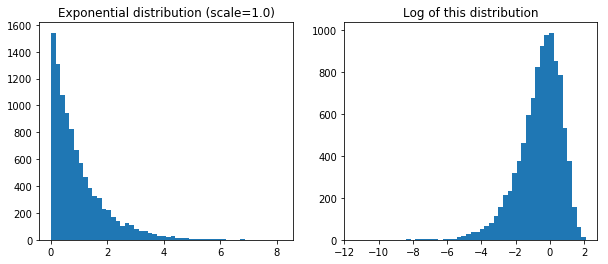

In [30]:
#A few words about the exponential and reciprocal functions used in RandomizedSearchCV.  The expon object inherits
#from the rv_continuous class and can be used as a function to control the scale and size of the distribution.

expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)  #size=10000
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

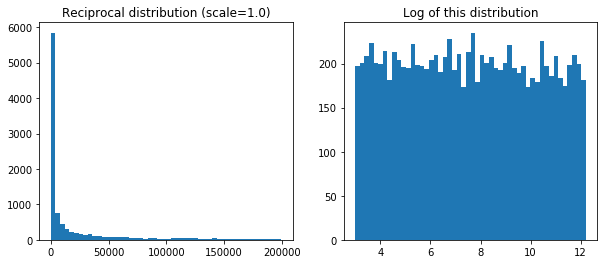

In [41]:
#The reciprocal object also inherits from the rv_continuous class and can be called as a function to fix the loc,
#scale, and shape parameters.  In reciprocal(a,b), parameters a and b control the shape of the distribution.  The
#reciprocal distribution is useful when you don't know what the scale of the hyperparameter should be.

reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()